In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
from os import path
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pickle
from torch.utils.data._utils.collate import default_collate
import gc
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


# Experiments to run

*   Softmax vs Sigmoid. If we're only taking the top prediction then softmax is probably better, but if we're doing multi-label then sigmoid might be better
*  Datasets
  * drug effects ~ 20%
  * drug effects + pca crispr ~ 4%
  * drug effects + autoencoder crispr
  * drug effects + pca expression ~ 4%
  * drug effects + autoencoder expression
  * drug effects + pca expression & crispr ~ 3%
  * drug effects + autoencoder expression & crispr
* Usual hyperparameters
* loss functions
  * **Cross entropy loss cannot deal with multiple MOAs for single sample, not sure how to handle**
  


# Load Data

In [0]:
"""
Data loader for achilles dataset run this file and look at __main__ for 
example of how to use
"""

"""
Specify files here
axis_val : dict( include_val:path_in_data_dir )
"""
DATASETS = {
  "cell_line": {
    "crispr": "imputed_crispr.npy", 
    "gene_expr": "norm_imputed_expression.npy", 
    #"pca_crispr": , # TODO
  },
  "drug": {
    "response": "drug/drug_only_overlap/norm_ov_dose_resp.npy",
    #"moa": "" # TODO
  }
}
GENE_LIST_FN = "clean_gene_list.npy"
CELL_LINES_FN = "clean_cell_lines.npy"
to_tensor = transforms.ToTensor()

class AchillesDataset(Dataset):

  def __init__(
    self, 
    data_fp="/content/drive/My Drive/Mr RIDC/Data",
    axis="cell_line",
    datasets=["crispr"],
    drug_feature_fp=None, # TODO replace with drug_features enum
    drug_feature_cell_fp=None
  ):
    """
    data_fp: path to directory that holds all of the data_files.
             Default is for collab. If running locally, must change
    axis: what one item is, must be "cell_line" or "drug"
          eg. if "cell_line", __getitem__ returns the crispr, rna for 1 cell line
    datasets: list of data types to include in output, different possible values 
              for depending on axis. To reduce memory usage, only include the data
              types you will actually use
    drug_feature_fp: path to .npy file where rows are cell lines and columns are
                     features
    drug_feature_cell_fp: cell ids in the order of rows of drug_feature_fp
    """
    self.axis = axis
    self.datasets = datasets
    if axis not in DATASETS.keys():
      raise ValueError(f"axis must be one of {DATASETS.keys()}")
    if any([ds not in DATASETS[axis].keys() for ds in datasets]):
      raise ValueError(f"datasets param must be in {DATASETS[axis].keys()}")
    are_drug_features = drug_feature_fp is not None and drug_feature_cell_fp is not None
    self.are_drug_features = are_drug_features
    if axis != "drug" and are_drug_features:
      raise ValueError("Can't use drug features unless we are iterating over drugs")

    # Maps from dataset to a tensor where each row represents a data point
    self.ds2table = {}
    
    if axis == "cell_line":
      for ds in datasets:
        numpy_fp = path.join(data_fp, DATASETS[axis][ds])
        self.ds2table[ds] = torch.squeeze(to_tensor(np.load(numpy_fp)))
      if "crispr" in datasets and "gene_expr" in datasets:
        crispr = self.ds2table["crispr"]
        expr = self.ds2table["gene_expr"]
        combined = np.stack([crispr, expr]).transpose((1,0,2))
        self.datasets.append("crispr_gene_expr")
        self.ds2table["crispr_gene_expr"] = combined
      # Read in metadata
      self.genes = np.load(path.join(data_fp, GENE_LIST_FN), allow_pickle=True)
      self.cells = np.load(path.join(data_fp, CELL_LINES_FN), allow_pickle=True)
    elif axis == "drug":
      # Drug response table
      self.drug_response = torch.squeeze(to_tensor(np.load(
        path.join(data_fp, "drug/drug_only_overlap/ov_dose_resp.npy"))))
      self.resp_broad_ids = np.load(
        path.join(data_fp, "drug/drug_only_overlap/ov_resp_drug.npy"))

      # Drug info table
      self.drug2moa_inds = pickle.load(
        open(path.join(data_fp, "drug/drug_only_overlap/drug2moa_inds.pi"), "rb")
      )
      self.moa_broad_ids = np.load(
        path.join(data_fp, "drug/drug_only_overlap/moa_broad_ids.npy"),
        allow_pickle=True
      )
      self.moas = np.load(
        path.join(data_fp, "drug/drug_only_overlap/moas.npy"),
        allow_pickle=True
      )
      self.cells = np.load(
        path.join(data_fp, "drug/drug_only_overlap/ov_resp_cell.npy"),
        allow_pickle=True
      )
      self.ds2table["response"] = self.drug_response

      if self.are_drug_features:
        # Read in drug feature vector table
        self.drug_feature = np.load(drug_feature_fp)
        self.drug_feature_cells = np.load(drug_feature_cell_fp, allow_pickle=True)

        # Get overlapping cells, only keep drug responses, features for those
        ov_cells = np.array(list(set(self.cells) & set(self.drug_feature_cells)))
        response_keep_inds = np.where(np.isin(self.cells, ov_cells))[0]
        feature_keep_inds = np.where(np.isin(self.drug_feature_cells, ov_cells))[0]

        # drug response holds the dosage which doesn't map to a cell line
        # saving it for later
        dosage = self.drug_response[:, 0]
        self.drug_response = self.drug_response[:, response_keep_inds]
        self.drug_feature = self.drug_feature[feature_keep_inds, :]

        self.cells = self.cells[response_keep_inds]
        self.drug_feature_cells = self.drug_feature_cells[feature_keep_inds]

        # Make order of responses, features match
        feature_sort_inds = np.argsort(self.drug_feature_cells)
        response_sort_inds = np.argsort(self.cells)

        self.cells = self.cells[response_sort_inds]
        self.drug_response = self.drug_response[:,response_sort_inds]

        self.drug_feature_cells = self.drug_feature_cells[feature_sort_inds]
        self.drug_feature = self.drug_feature[feature_sort_inds, :]

        # concatenate dosage back into drug response
        self.drug_response = np.concatenate([dosage[:,np.newaxis], self.drug_response], axis=1)

        # Stack the features onto our drug response matrix
        # For now, replicating the dosage value accross all features
        n_drug = self.drug_response.shape[0]
        n_feat = self.drug_feature.shape[1]
        stack_features = np.tile(self.drug_feature, (n_drug, 1, 1))
        dosage = np.array(dosage)
        stack_dosage = np.tile(dosage[:,np.newaxis], (1,1,n_feat)).transpose((1,0,2))
        to_stack = np.concatenate((stack_dosage, stack_features), axis=1)
        self.drug_response = np.concatenate(
          (self.drug_response[:,:,np.newaxis], to_stack), axis=2)
        #dosage_stack = np.tile(dosage[:,np.newaxis])
        #stack_features = np.concate([np.zeros])
    

  def __len__(self):
    if self.axis == "cell_line":
      return self.ds2table[self.datasets[0]].shape[0]
    else:
      return self.drug_response.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    out_dict = {}
    if self.axis == "cell_line":
      for ds in self.datasets:
        tbl = self.ds2table[ds]
        if len(tbl.shape) == 2:
          out_dict[ds] = tbl[idx, :]
        elif len(tbl.shape) == 3:
          out_dict[ds] = tbl[idx, :, :]
    else:
      drug = self.resp_broad_ids[idx]
      moa_inds = self.drug2moa_inds[drug]
      if self.are_drug_features:
        response = self.drug_response[idx,:,:]
      else:
        response = self.drug_response[idx,:]
      out_dict = {
        "response": response,
        "drug": drug,
        "moa_ind": torch.Tensor(moa_inds),
      }

    return out_dict


In [0]:

if __name__ == "__main__":
  def drug_collate_fn(batch):
    moas = []
    for s in batch:
      moas.append(s["moa_ind"].int().tolist())
      del s["moa_ind"]
    out_dict = default_collate(batch)
    out_dict["moa_ind"] = moas
    return out_dict

  print("----------Iterating over cell lines-----------")
  #DD = "/Users/massoudmaher/Documents/Code/mr-ridc/data"
  DD = "/content/drive/My Drive/Mr RIDC/Data"

  # cell_achilles_loader = DataLoader(cell_achilles, batch_size=4, shuffle=False)
  # i = 0
  # for batch in cell_achilles_loader:
  #   print("batch[\"crispr\"].shape")
  #   print(batch["crispr"].shape)
  #   print("batch[\"gene_expr\"].shape")
  #   print(batch["gene_expr"].shape)
  #   print("batch[\"crispr_gene_expr\"].shape")
  #   print(batch["crispr_gene_expr"].shape)

  #   if i == 2:
  #     break
  #   i += 1

  # print("cell_achilles.genes holds gene names in correct order")
  # print(cell_achilles.genes[:5])
  # print("cell_achilles.cells holds cell line names in correct order")
  # print(cell_achilles.cells[:5])

  print("\n\n----------Iterating over drugs----------")
  drug_achilles = AchillesDataset(
    data_fp=DD,
    axis="drug",
    datasets=["response"]
  )


  drug_loader = DataLoader(drug_achilles, batch_size=4, shuffle=True, 
                           collate_fn=drug_collate_fn)
  i = 0
  for batch in drug_loader:
    print("batch[\"response\"].shape")
    print(batch["response"].shape)
    print("First column is dosage!!!!")

    print("drug_achilles.cells holds cells in same order as batch[response] cols")
    print(drug_achilles.cells[:5])
    print("note that drug_achilles.cells.shape is 1 less since the first column is dosage")
    print(drug_achilles.cells.shape)

    print("batch[\"drug\"]")
    print(batch["drug"])

    print("batch[\"moa_ind\"]")
    moa_inds = batch["moa_ind"]
    print(moa_inds)

    print("corresponding moas")
    print([drug_achilles.moas[list(i)] for i in moa_inds])


    if i == 2:
      break
    i += 1
  
  print("\n\n----Iterating over drugs with feature vectors for each cell line CRISPR ONLY-----")
  print("The data was already subsetted by only taking cell lines and genes that overlap between crispr and RNA-seq")
  feat_drug_achilles = AchillesDataset(
    data_fp=DD,
    axis="drug",
    datasets=["response"],
    drug_feature_fp=path.join(DD, "pca50_imputed_crispr.npy"),
    drug_feature_cell_fp=path.join(DD, "clean_cell_lines.npy")
  )
  feat_drug_loader = DataLoader(feat_drug_achilles, batch_size=4, shuffle=True, 
                                collate_fn=drug_collate_fn)
  i = 0
  for batch in feat_drug_loader:
    print("batch[\"response\"].shape")
    print(batch["response"].shape)
    print("First column is dosage!!!!")

    if i == 2:
      break
    i += 1

  # Garbage collect so we don't overload memory
  feat_drug_achilles, feat_drug_loader = None, None
  gc.collect()
  print("\n\n----Iterating over drugs with feature vectors for each cell line EXPRESSION ONLY-----")
  print("The data was already subsetted by only taking cell lines and genes that overlap between crispr and RNA-seq")
  feat_drug_achilles = AchillesDataset(
    data_fp=DD,
    axis="drug",
    datasets=["response"],
    drug_feature_fp=path.join(DD, "pca50_imp_expr.npy"),
    drug_feature_cell_fp=path.join(DD, "clean_cell_lines.npy")
  )
  feat_drug_loader = DataLoader(feat_drug_achilles, batch_size=4, shuffle=True, 
                                collate_fn=drug_collate_fn)
  i = 0
  for batch in feat_drug_loader:
    print("batch[\"response\"].shape")
    print(batch["response"].shape)
    print("First column is dosage!!!!")

    if i == 2:
      break
    i += 1

  #Garbage collect so we don't overload memory
  feat_drug_achilles, feat_drug_loader = None, None
  gc.collect()
  print("\n\n----Iterating over drugs with feature vectors for each cell line CRISPR AND EXPRESSION-----")
  print("The data was already subsetted by only taking cell lines and genes that overlap between crispr and RNA-seq")
  feat_drug_achilles = AchillesDataset(
    data_fp=DD,
    axis="drug",
    datasets=["response"],
    drug_feature_fp=path.join(DD, "pca50_imp_crispr_expr.npy"),
    drug_feature_cell_fp=path.join(DD, "clean_cell_lines.npy")
  )
  feat_drug_loader = DataLoader(feat_drug_achilles, batch_size=12, shuffle=True, 
                                collate_fn=drug_collate_fn)
  i = 0
  for batch in feat_drug_loader:
    print("batch[\"response\"].shape")
    print(batch["response"].shape)
    print("First column is dosage!!!!")

    if i == 2:
      break
    i += 1


----------Iterating over cell lines-----------


----------Iterating over drugs----------
batch["response"].shape
torch.Size([4, 490])
First column is dosage!!!!
drug_achilles.cells holds cells in same order as batch[response] cols
['ACH-000007' 'ACH-000008' 'ACH-000010_FAILED_STR' 'ACH-000011'
 'ACH-000012']
note that drug_achilles.cells.shape is 1 less since the first column is dosage
(489,)
batch["drug"]
['BRD-K16803204-001-01-6', 'BRD-K87909389-003-03-4', 'BRD-K75649340-001-13-1', 'BRD-K73303757-001-21-6']
batch["moa_ind"]
[[66], [21], [377], [374]]
corresponding moas
[array(['JAK inhibitor'], dtype=object), array(['CDK inhibitor'], dtype=object), array(['purine antagonist'], dtype=object), array(['protein tyrosine kinase inhibitor'], dtype=object)]
batch["response"].shape
torch.Size([4, 490])
First column is dosage!!!!
drug_achilles.cells holds cells in same order as batch[response] cols
['ACH-000007' 'ACH-000008' 'ACH-000010_FAILED_STR' 'ACH-000011'
 'ACH-000012']
note that drug_

# Scoring

In [0]:
def accuracy(preds, labels):
  correct = 0
  total = 0
  for i in range(preds.shape[0]):
    if torch.argmax(preds[i]) in (labels[i] == 1).nonzero().flatten():
      correct += 1
    total += 1
  return correct/total


In [0]:
# simple accuracy
def pred_acc(preds, labels):
  return torch.round(preds).eq(labels).sum().numpy()/len(labels)

# Classifier

## Nets

In [0]:
def hot_encode_moa_batch(moa_batch):
  moa_encoding_for_batch = []
  # Each record in the batch will have a list of moa's
  for moa_list in moa_batch:
    moa_encoding = hot_encode_moa(moa_list)
    moa_encoding_for_batch.append(moa_encoding)
  return np.array(moa_encoding_for_batch)

# Returns a one-hot encoded MOA list
def hot_encode_moa(moa_list):
  # How many moa's are there? 444
  moa_vec = np.zeros((444,))
  for moa_index in moa_list:
    moa_vec[moa_index] = 1
  return moa_vec

In [0]:
# If there can be more than one target it's called "multi-label classification"
# Can we still use sigmoid?
class VanillaClassifier(nn.Module):
    #def __init__(self, batch_size, input_size, fc1_dim = 4000, fc2_dim = 500, fc3_dim = 100):
    def __init__(self, batch_size, input_size, fc1_dim = 2000, fc2_dim = 4000, fc3_dim = 2000):
        super().__init__()
        self.layer1 = nn.Sequential(
          nn.Linear(input_size, fc1_dim),
          nn.ReLU(),
          nn.Linear(fc1_dim, fc2_dim),
          nn.ReLU(),
          nn.Linear(fc2_dim, fc3_dim),
          nn.ReLU(),
          nn.Linear(fc3_dim, 444),
          nn.Sigmoid()
        )
        self.shape = input_size
        self.batch_size = batch_size

    def forward(self, input_seq):
      predictions = self.layer1(input_seq)
      # predictions = predictions.view(self.batch_size, -1)
      return predictions

In [0]:
class DeepClassifier(nn.Module):
    #def __init__(self, batch_size, input_size, fc1_dim = 4000, fc2_dim = 500, fc3_dim = 100):
    def __init__(self, batch_size, input_size, fc1_dim = 4000, fc2_dim = 3000, fc3_dim = 2500, fc4_dim=2200, fc5_dim=2000, fc6_dim=2000, fc7_dim=2000):
        super().__init__()
        self.layer1 = nn.Sequential(
          nn.Linear(input_size, fc1_dim),
          nn.ReLU(),
          nn.Dropout(.2),
          nn.Linear(fc1_dim, fc2_dim),
          nn.ReLU(),
          nn.Dropout(.2),
          nn.Linear(fc2_dim, fc3_dim),
          nn.ReLU(),
          nn.Dropout(.2),
          nn.Linear(fc3_dim, fc4_dim),
          nn.ReLU(),
          nn.Linear(fc4_dim, fc5_dim),
          nn.ReLU(),
          nn.Linear(fc5_dim, fc6_dim),
          nn.ReLU(),
          nn.Linear(fc6_dim, fc7_dim),
          nn.ReLU(),
          nn.Linear(fc7_dim, 444),
          nn.Sigmoid()
        )
        self.shape = input_size
        self.batch_size = batch_size

    def forward(self, input_seq):
      predictions = self.layer1(input_seq)
      # predictions = predictions.view(self.batch_size, -1)
      return predictions

In [0]:
class DeepClassifier2(nn.Module):
    #def __init__(self, batch_size, input_size, fc1_dim = 4000, fc2_dim = 500, fc3_dim = 100):
    #def __init__(self, batch_size, input_size, fc1_dim = 4000, fc2_dim = 3000, fc3_dim = 2500, fc4_dim=2200, fc5_dim=2000, fc6_dim=2000, fc7_dim=2000):
    def __init__(self, batch_size, input_size, fc1_dim = 1000, fc2_dim = 2000, fc3_dim = 2500, fc4_dim=4000, fc5_dim=3000, fc6_dim=2000, fc7_dim=1000):
        super().__init__()
        self.layer1 = nn.Sequential(
          nn.Linear(input_size, fc1_dim),
          nn.LeakyReLU(),
          nn.Dropout(.1),
          nn.Linear(fc1_dim, fc2_dim),
          nn.LeakyReLU(),
          nn.Dropout(.1),
          nn.Linear(fc2_dim, fc3_dim),
          nn.LeakyReLU(),
          nn.Dropout(.1),
          nn.Linear(fc3_dim, fc4_dim),
          nn.LeakyReLU(),
          nn.Linear(fc4_dim, fc5_dim),
          nn.LeakyReLU(),
          nn.Linear(fc5_dim, fc6_dim),
          nn.LeakyReLU(),
          nn.Linear(fc6_dim, fc7_dim),
          nn.LeakyReLU(),
          nn.Linear(fc7_dim, 444),
          nn.Softmax()
        )
        self.shape = input_size
        self.batch_size = batch_size

    def forward(self, input_seq):
      predictions = self.layer1(input_seq)
      # predictions = predictions.view(self.batch_size, -1)
      return predictions

In [0]:
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, batch_size, input_size):
        super(ConvNet, self).__init__()
        self.batch_size = batch_size
        self.shape = input_size
        self.conv1 = nn.Conv1d(339, 100, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv1d(50, 25, 3)
        self.fc1 = nn.Linear(132, 125)
        self.fc2 = nn.Linear(125, 240)
        self.fc3 = nn.Linear(240, 444)
        self.out = nn.Softmax()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(self.batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.out(x)
        return x

In [0]:
import torch.nn.functional as F

class ConvNet_feat(nn.Module):
    def __init__(self, batch_size, input_size):
        super(ConvNet_feat, self).__init__()
        self.batch_size = batch_size
        self.shape = input_size
        self.conv1 = nn.Conv1d(339, 100, 3)
        self.bn1 = nn.BatchNorm1d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop_layer = nn.Dropout(0.2)
        self.conv2 = nn.Conv1d(50, 25, 3)
        self.bn2 = nn.BatchNorm1d(25)
        self.fc1 = nn.Linear(132, 125)
        self.fc2 = nn.Linear(125, 240)
        self.fc3 = nn.Linear(240, 444)
        self.out = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.pool(F.relu(self.bn2(x)))
        x = self.drop_layer(x)
        x = x.view(self.batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.out(x)
        return x

In [0]:
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, batch_size, input_size):
        super(ConvNet, self).__init__()
        self.batch_size = batch_size
        self.shape = input_size
        #self.conv1 = nn.Conv1d(339, 100, 3)
        self.conv1 = nn.Conv1d(490, 800, 1)
        self.bn1 = nn.BatchNorm1d(800)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv1d(400, 490, 1)
        self.bn2 = nn.BatchNorm1d(490)
        self.fc1 = nn.Linear(3, 245)
        self.fc2 = nn.Linear(245, 444)
        #self.fc3 = nn.Linear(240, 444)
        self.out = nn.Softmax()

    def forward(self, x):
        print("x.shape")
        print(x.shape)
        x = x.view(-1, 490, 12)
        x = self.conv1(x)
        x = self.pool(F.relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.pool(F.relu(self.bn2(x)))
        #x = x.view(735, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        x = self.out(x)
        return x

## Training function

In [0]:
def train(criterion, learningRate, batchSize, dataset, dropout = False, dropoutRate = 0, returnModel = True, testModel = False):
  # set up data loader
  trainSet, testSet = torch.utils.data.random_split(dataset, [9939, 2485])

  trainLoader = DataLoader(trainSet, batch_size=batchSize, shuffle=True, 
                          collate_fn=drug_collate_fn, drop_last=True)

  tensor_shape = iter(trainLoader).next()['response'].shape
  print(tensor_shape)
  shape = tensor_shape[1]
  for i in tensor_shape[2:]:
    shape = shape * i
  returnObjects = []
  
  # CHANGE CLASSIFIER HERE
  #classifier = DeepClassifier2(batchSize, shape).to(device)
  classifier = DeepClassifier(batchSize, shape).to(device)
  #classifier = VanillaClassifier(batchSize, shape).to(device)
  #classifier = ConvNet(batchSize, shape).to(device)
  #classifier = ConvNet_feat(batchSize, shape).to(device)


  # hyper parameters
  optimizer = torch.optim.Adam(classifier.parameters(), lr=learningRate)
  epochs = 20

  # training loop
  losses_train = []
  for i in tqdm(range(epochs)):
    loss = 0 # For keeping variable in scope
    for batch in trainLoader:
      # USE FOR BCE
      moa_hot_encoded = torch.tensor(hot_encode_moa_batch(batch['moa_ind'])).float().to(device)

      #USE FOR CROSS ENTROPY
      moa_hot_encoded = torch.tensor(hot_encode_moa_batch(batch['moa_ind']), dtype=torch.long).to(device)
      dosage_drug_response = batch['response'].float().to(device)
      dosage_drug_response[torch.isnan(dosage_drug_response)] = 0 # Sets nan's to 0
      dosage_drug_response = dosage_drug_response.reshape(batchSize, -1) # for fc classifiers
      optimizer.zero_grad()
      preds = classifier(dosage_drug_response)

      # USE FOR CROSS ENTROPY
      #loss = criterion(preds, torch.max(moa_hot_encoded, 1)[1])
      # USE FOR BINARY CROSS ENTROPY
      loss = criterion(preds, moa_hot_encoded.float())

      loss.backward()
      optimizer.step()
    losses_train.append(loss)
    print("Epoch: " + str(i) +" Loss: " + str(loss))

  # graph loss
  plt.plot(losses_train)
  plt.title("Training Loss Per Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  # test
  if testModel == True:
    testLoader = DataLoader(testSet, batch_size=batchSize, shuffle=True, 
                          collate_fn=drug_collate_fn, drop_last=True)
    accuracy = test(testLoader, classifier, criterion, batchSize)
    returnObjects.append(accuracy)

  if returnModel == True:
    returnObjects.append(classifier)

  return returnObjects


In [0]:
def test(testLoader, classifier, criterion, batchSize):
  losses_test = []
  test_preds = torch.empty(0).to(device)
  test_labels = torch.empty(0).to(device)
  # Get validation accuracy
  with torch.no_grad():
    for batch in testLoader: 
        moa_hot_encoded = torch.tensor(hot_encode_moa_batch(batch['moa_ind'])).float().to(device)
        #USE FOR CROSS ENTROPY
        moa_hot_encoded = torch.tensor(hot_encode_moa_batch(batch['moa_ind']), dtype=torch.long).to(device)

        dosage_drug_response = batch['response'].float().to(device)
        dosage_drug_response[torch.isnan(dosage_drug_response)] = 0 # Sets nan's to 0
        dosage_drug_response = dosage_drug_response.reshape(batchSize, -1) # for fc classifiers
        preds = classifier(dosage_drug_response)
        loss = criterion(preds, moa_hot_encoded.float())
        # USE FOR CROSS ENTROPY
        #loss = criterion(preds, torch.max(moa_hot_encoded, 1)[1])

        test_preds = torch.cat((test_preds, preds.float()))
        #moa_hot_encoded = torch.tensor(hot_encode_moa_batch(batch['moa_ind'])).float().to(device)
        test_labels = torch.cat((test_labels, moa_hot_encoded.float()))
  acc = accuracy(test_preds, test_labels)
  
  print (acc*100)
  return acc

## Train with Drug only

### Deep net 2

torch.Size([12, 490])


Epoch: 0 Loss: tensor(0.0144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 1 Loss: tensor(0.0184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 2 Loss: tensor(0.0218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 3 Loss: tensor(0.0188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 4 Loss: tensor(0.0150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 5 Loss: tensor(0.0133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 6 Loss: tensor(0.0168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 7 Loss: tensor(0.0143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 8 Loss: tensor(0.0134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 9 Loss: tensor(0.0161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 10 Loss: tensor(0.0114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 11 Loss: tensor(0.0143, device='cuda:0', grad_fn=<BinaryC

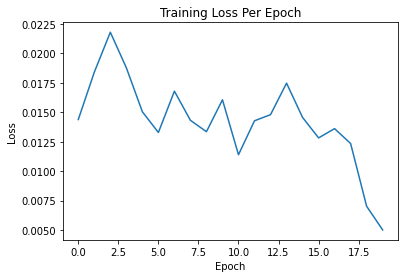

13.607085346215781


In [0]:
#Deep Network 2
try:
  del classifier
  torch.cuda.empty_cache()
  gc.collect()
except:
  pass
classifierResults = train(nn.BCELoss(), .0001, 12, drug_achilles, testModel=True)

In [0]:
import pickle
pickle.dump(classifierResults, open(path.join(DD, "models/deep_net2.pickle"), "wb"))

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


### Deep Net

torch.Size([12, 490])


Epoch: 0 Loss: tensor(0.0169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 1 Loss: tensor(0.0187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 2 Loss: tensor(0.0139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 3 Loss: tensor(0.0160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 4 Loss: tensor(0.0166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 5 Loss: tensor(0.0169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 6 Loss: tensor(0.0154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 7 Loss: tensor(0.0169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 8 Loss: tensor(0.0149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 9 Loss: tensor(0.0123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 10 Loss: tensor(0.0174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 11 Loss: tensor(0.0153, device='cuda:0', grad_fn=<BinaryC

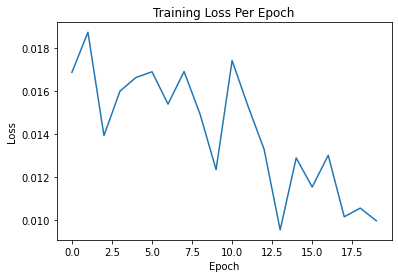

13.929146537842191


/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [0]:
#Deep Network
try:
  del classifier
  torch.cuda.empty_cache()
  gc.collect()
except:
  pass
classifierResults = train(nn.BCELoss(), .0001, 12, drug_achilles, testModel=True)
import pickle
pickle.dump(classifierResults, open(path.join(DD, "models/deep_net.pickle"), "wb"))

### Vanilla

torch.Size([12, 490])


Epoch: 0 Loss: tensor(0.0179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 1 Loss: tensor(0.0190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 2 Loss: tensor(0.0130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 3 Loss: tensor(0.0134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 4 Loss: tensor(0.0105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 5 Loss: tensor(0.0080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 6 Loss: tensor(0.0083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 7 Loss: tensor(0.0062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 8 Loss: tensor(0.0055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 9 Loss: tensor(0.0049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 10 Loss: tensor(0.0032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 11 Loss: tensor(0.0027, device='cuda:0', grad_fn=<BinaryC

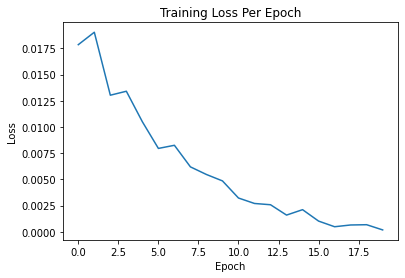

23.10789049919485


/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [0]:
#Vanilla
try:
  del classifier
  torch.cuda.empty_cache()
  gc.collect()
except:
  pass
classifierResults = train(nn.BCELoss(), .0001, 12, drug_achilles, testModel=True)
import pickle
pickle.dump(classifierResults, open(path.join(DD, "models/norm_vanilla.pickle"), "wb"))

### CNN

In [0]:
#CNN
try:
  del classifier
  torch.cuda.empty_cache()
  gc.collect()
except:
  pass
classifierResults = train(nn.CrossEntropyLoss(), .001, 128, feat_drug_achilles, testModel=True)
pickle.dump(classifierResults, open(path.join(DD, "models/norm_cnn.pickle"), "wb"))

torch.Size([128, 339, 51])


RuntimeError: ignored

In [0]:
#CNN
try:
  del classifier
  torch.cuda.empty_cache()
  gc.collect()
except:
  pass
classifierResults = train(nn.BCELoss(), .0002, 12, feat_drug_achilles, testModel=True)

In [0]:
#CNN
try:
  del classifier
  torch.cuda.empty_cache()
  gc.collect()
except:
  pass
classifierResults = train(nn.BCELoss(), .0002, 12, feat_drug_achilles, testModel=True)

In [0]:
#Vanilla Network
try:
  del classifier
  torch.cuda.empty_cache()
  gc.collect()
except:
  pass
classifierResults = train(nn.BCELoss(), .0002, 12, drug_achilles, testModel=True)

In [0]:
#Vanilla Network with Cross Entropy
try:
  del classifier
  torch.cuda.empty_cache()
  gc.collect()
except:
  pass
classifierResults = train(nn.BCELoss(), .005, 48, drug_achilles, testModel=True)

In [0]:
#Vanilla Network with Cross Entropy
try:
  del classifier
  torch.cuda.empty_cache()
  gc.collect()
except:
  pass
classifierResults = train(nn.CrossEntropyLoss(), .0002, 48, drug_achilles, testModel=True)

## Train with Drug + Feature

### Vanilla

In [0]:
try:
  del classifier
  torch.cuda.empty_cache()
  gc.collect()
except:
  pass
classifierResults = train(nn.BCELoss(), .0002, 4, feat_drug_achilles, testModel=True)

### Deep Net

In [0]:
try:
  del classifier
  torch.cuda.empty_cache()
  gc.collect()
except:
  pass
classifierResults = train(nn.BCELoss(), .0001, 12, feat_drug_achilles, testModel=True)
import pickle
pickle.dump(classifierResults, open(path.join(DD, "models/norm_pca_feat_deep.pickle"), "wb"))

In [0]:
def saveModel(model, filename):
  torch.save(model, "/content/drive/My Drive/Mr RIDC/" + filename)

In [0]:
# Need to get data
# Each batch has x records where x is batch_size
# Each record has a drug string, an moa list, and 
# a response array of length 490 where the first record is the dosage
# So really, response for 489 cell lines

# May have to align with other sets in future that have fewer cell lines
# Option to one-hot encode drug name to save that info to have for the network
# Do we need to normalize dosage?
# Create test set / test dataloader
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


# 80 - 20 Train/Test split
train_set, val_set = torch.utils.data.random_split(feat_drug_achilles, [9939, 2485])
batch_size = 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
                          collate_fn=drug_collate_fn, drop_last=True)

classifier = VanillaClassifier().to(device)
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0002)
epochs = 50


losses_train = []
for i in range(epochs):
  loss = 0 # For keeping variable in scope
  for batch in train_loader: 
    moa_hot_encoded = torch.tensor(hot_encode_moa_batch(batch['moa_ind'])).float().to(device)
    dosage_drug_response = batch['response'].float().to(device)
    dosage_drug_response[torch.isnan(dosage_drug_response)] = 0 # Sets nan's to 0
    optimizer.zero_grad()
    preds = classifier(dosage_drug_response.flatten())
    loss = loss_function(preds, moa_hot_encoded)
    loss.backward()
    optimizer.step()
  losses_train.append(loss)
  print("Epoch: " + str(i) +" Loss: " + str(loss))




In [0]:
plt.plot(losses_train)
plt.title("Training Loss Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Drug + autoencoded features

### Vanilla

In [0]:
try:
  del classifier
  del feat_drug_achilles
  torch.cuda.empty_cache()
  gc.collect()
except:
  pass

ae_feat_drug_achilles = AchillesDataset(
    data_fp=DD,
    axis="drug",
    datasets=["response"],
    drug_feature_fp=path.join(DD, "v2_ae_cells.npy"),
    drug_feature_cell_fp=path.join(DD, "clean_cell_lines.npy")
)

aeFeatClassifierResults = train(nn.BCELoss(), .0002, 4, ae_feat_drug_achilles, testModel=True)
pickle.dump(classifierResults, open(path.join(DD, "models/norm_feat_ae_vanilla.pickle"), "wb"))

### Deep Net

torch.Size([4, 339, 201])


Epoch: 0 Loss: tensor(0.2252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 1 Loss: tensor(0.2815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 2 Loss: tensor(0.2252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 3 Loss: tensor(0.2252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 4 Loss: tensor(0.2252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 5 Loss: tensor(0.2252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 6 Loss: tensor(0.2252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 7 Loss: tensor(0.2252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 8 Loss: tensor(0.4505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 9 Loss: tensor(0.2252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 10 Loss: tensor(0.2252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Epoch: 11 Loss: tensor(0.2252, device='cuda:0', grad_fn=<BinaryC

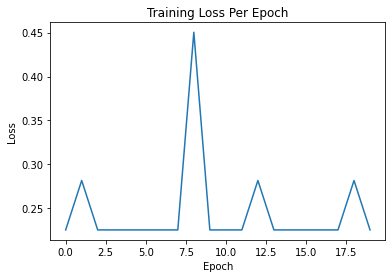

0.322061191626409


NameError: ignored

In [19]:
try:
  del classifier
  del feat_drug_achilles
  torch.cuda.empty_cache()
  gc.collect()
except:
  pass

DD = "/content/drive/My Drive/Mr RIDC/Data"
def drug_collate_fn(batch):
  moas = []
  for s in batch:
    moas.append(s["moa_ind"].int().tolist())
    del s["moa_ind"]
  out_dict = default_collate(batch)
  out_dict["moa_ind"] = moas
  return out_dict
ae_feat_drug_achilles = AchillesDataset(
    data_fp=DD,
    axis="drug",
    datasets=["response"],
    drug_feature_fp=path.join(DD, "v2_ae_cells.npy"),
    drug_feature_cell_fp=path.join(DD, "clean_cell_lines.npy")
)

aeFeatClassifierResults = train(nn.BCELoss(), .0002, 4, ae_feat_drug_achilles, testModel=True)
pickle.dump(classifierResults, open(path.join(DD, "models/norm_feat_ae_deep_net.pickle"), "wb"))